Loading annotated data from: /mnt/data/project/25_04_29_Figure3_reanalysis/processed_data/merged_v9/Annotated_phenotype_hypr_seq_MERGED_with_donor_clusters.h5ad
Data loaded successfully:
AnnData object with n_obs × n_vars = 46913 × 1276
    obs: 'n_counts', 'condition', 'batch', 'sample_name', 'sample_key', 'AAV_control', 'JAK1-R360W_het_bystander', 'JAK1-R360W_het_pure', 'JAK1-R360W_hom_bystander', 'JAK1-R360W_hom_pure', 'JAK1-T147A_het_bystander', 'JAK1-T147A_het_pure', 'JAK1-T147A_hom_bystander', 'JAK1-T147A_hom_pure', 'JAK1-SPA5_het_bystander', 'JAK1-SPA5_het_pure', 'JAK1-SPA5_hom_bystander', 'JAK1-SPA5_hom_pure', 'JAK1-E83K_het_bystander', 'JAK1-E83K_het_pure', 'JAK1-E83K_hom_bystander', 'JAK1-E83K_hom_pure', 'STAT1-L600P_het_bystander', 'STAT1-L600P_het_pure', 'STAT1-L600P_hom_bystander', 'STAT1-L600P_hom_pure', 'STAT1-A402T_het_bystander', 'STAT1-A402T_het_pure', 'STAT1-A402T_hom_bystander', 'STAT1-A402T_hom_pure', 'STAT1-A401T_het_bystander', 'STAT1-A401T_het_pure', 'STAT1-A401

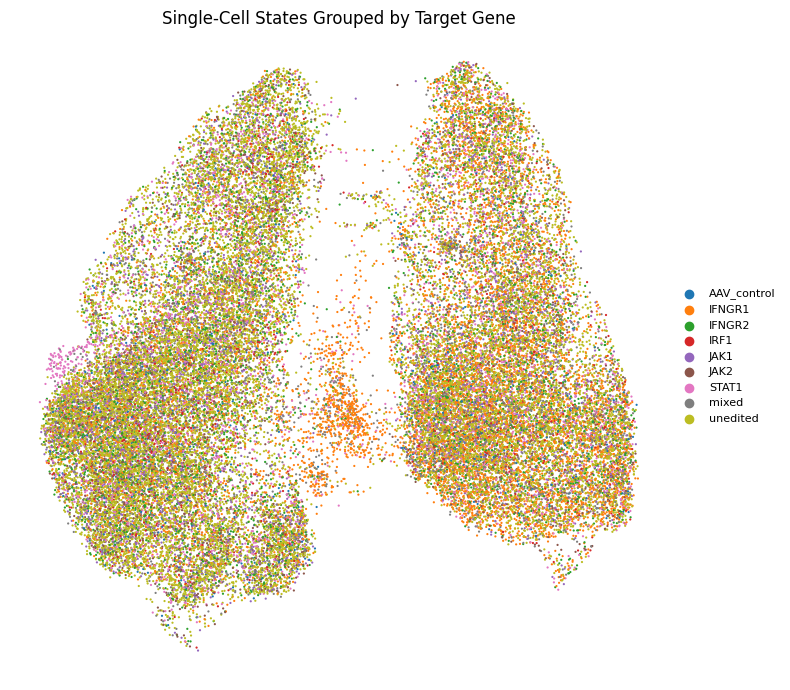

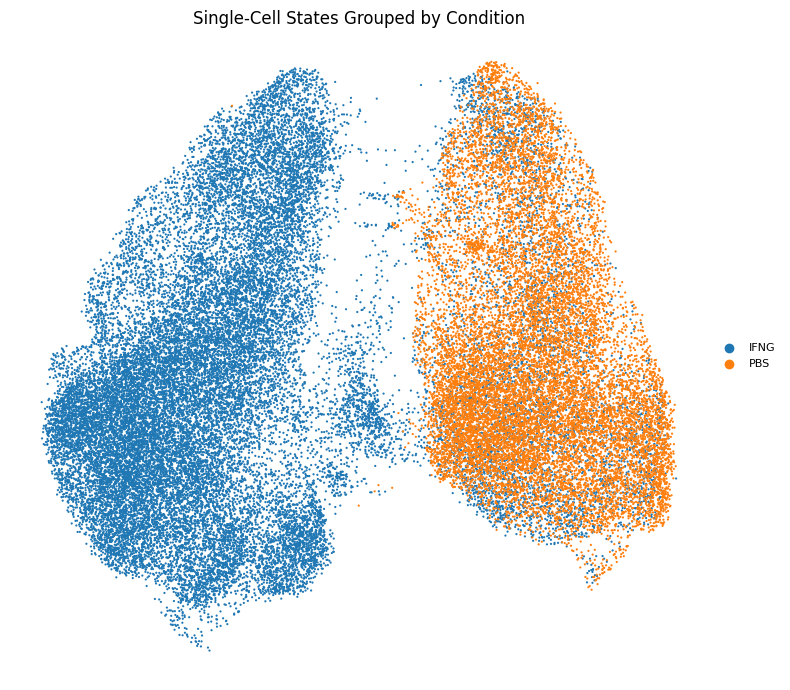

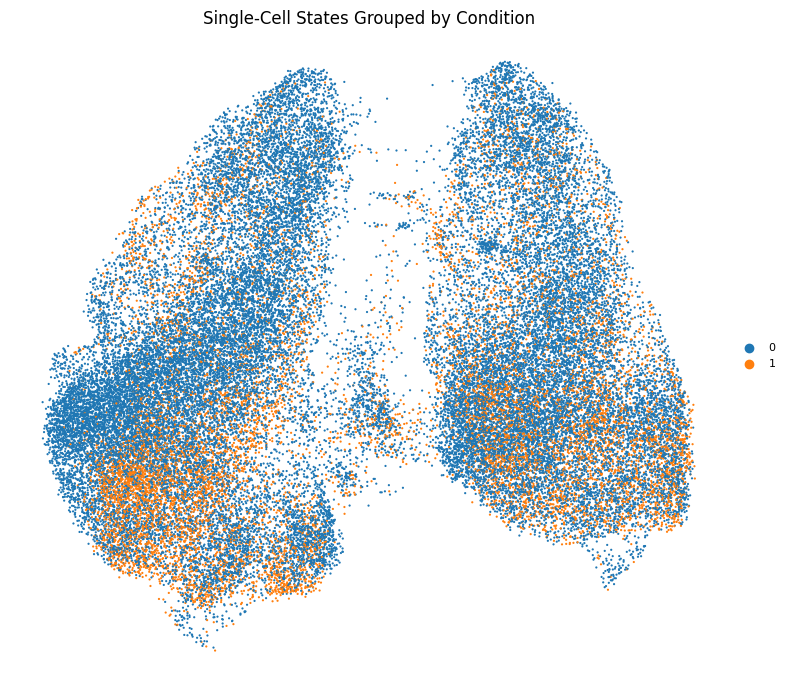

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re # For regular expression matching
from pathlib import Path

# --- Configuration ---

# 1. Path to your annotated AnnData file
adata_file = '/mnt/data/project/25_04_29_Figure3_reanalysis/processed_data/merged_v9/Annotated_phenotype_hypr_seq_MERGED_with_donor_clusters.h5ad' # Output from the previous integration step

# 2. Column containing the detailed genotype annotations
genotype_col = 'genotype_annotation' # UPDATE if your column name is different

# 3. Define control labels present in the genotype column
control_labels = ['unedited', 'mixed', 'AAV_control'] # UPDATE if your control labels differ

# 4. Output path for the figure
output_plot_dir = Path('./Figure3b') # Directory to save the plot
output_plot_dir.mkdir(parents=True, exist_ok=True)
output_plot_file = output_plot_dir / 'Fig3a_UMAP_TargetGeneGroup.png'
# Consider saving as PDF or SVG for publication quality:
# output_plot_file = output_plot_dir / 'Fig3a_UMAP_TargetGeneGroup.pdf'

# 5. Plotting parameters
umap_point_size = 10 # Adjust based on cell number (smaller for more cells)
umap_figsize = (8, 7)
umap_fontsize = 10
umap_legend_fontsize = 8

# --- Load Data ---
print(f"Loading annotated data from: {adata_file}")
try:
    adata = sc.read_h5ad(adata_file)
    print("Data loaded successfully:")
    print(adata)
    if genotype_col not in adata.obs.columns:
        raise ValueError(f"Column '{genotype_col}' not found in adata.obs.")
except FileNotFoundError:
    print(f"Error: AnnData file not found at {adata_file}.")
    exit()
except ValueError as ve:
     print(f"Error: {ve}")
     exit()
except Exception as e:
    print(f"An error occurred loading the AnnData file: {e}")
    exit()

# --- Preprocessing Check (Optional but Recommended) ---
# Ensure UMAP coordinates exist. If not, run the pipeline.
# This assumes standard preprocessing was done before saving the annotated object.
# If you need to re-run it, uncomment and adapt the following section:
print("Checking/Running Preprocessing for UMAP...")
if 'X_umap' not in adata.obsm:
    print("UMAP coordinates not found. Running preprocessing pipeline...")
    # Ensure basic filtering was done previously
    # Normalize counts
    sc.pp.filter_cells(adata, min_counts=500)
    sc.pp.normalize_total(adata, target_sum=1e4)
    # Log-transform
    sc.pp.log1p(adata)
    # Identify highly variable genes
    #sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=3000) # Adjust n_top_genes
    #adata_hvg = adata[:, adata.var.highly_variable].copy()
    # Scale data
    # sc.pp.scale(adata_hvg, max_value=10)
    # PCA
    sc.tl.pca(adata, svd_solver='arpack')
    # Neighbors
    # Adjust n_pcs based on PCA variance plot if needed
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
    # UMAP
    sc.tl.umap(adata)

elif 'X_pca' not in adata.obsm or 'neighbors' not in adata.uns:
     print("Warning: UMAP found, but PCA/neighbors might be missing. Plotting existing UMAP.")
else:
    print("Existing UMAP coordinates found.")

# Ensure UMAP coordinates exist before proceeding
if 'X_umap' not in adata.obsm:
    print("Error: UMAP coordinates ('X_umap') not found in adata.obsm. Please run preprocessing first.")
    exit()

# --- Create Target Gene Grouping ---
print(f"Creating 'target_gene_group' column from '{genotype_col}'...")

def get_target_group(annotation):
    """Parses the genotype annotation string to extract the target gene/group."""
    annotation = str(annotation) # Ensure it's a string
    if annotation in control_labels:
        return annotation # Keep control labels as they are

    # Match pattern like 'GENE-...' or 'GENE_'
    match = re.match(r'^([A-Z0-9]+)[-_]', annotation, re.IGNORECASE)
    if match:
        return match.group(1).upper() # Return the captured gene name (uppercase)
    else:
        # Handle cases that don't match the expected pattern (e.g., just 'GENE')
        # Or return a default 'Other' category if needed
        return 'Other_Perturbation' # Or return annotation itself if preferred

# Apply the function to create the new column
adata.obs['target_gene_group'] = adata.obs[genotype_col].apply(get_target_group).astype('category')

print("Value counts for 'target_gene_group':")
print(adata.obs['target_gene_group'].value_counts())

# --- Define Color Palette ---
print("Defining color palette...")
unique_groups = adata.obs['target_gene_group'].cat.categories.tolist()
n_colors = len(unique_groups)

# Generate a colormap (e.g., tab20 or a custom list)
# Try to get visually distinct colors. tab20 + tab20b + tab20c can give more colors.
# For >20, consider 'glasbey_dark' from colorcet if installed (pip install colorcet)
if n_colors <= 20:
    # Use tab20, good for up to 20 distinct categories
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i / n_colors) for i in range(n_colors)]
elif n_colors <= 40:
     # Combine tab20b and tab20c
     cmap_b = plt.get_cmap('tab20b')
     cmap_c = plt.get_cmap('tab20c')
     colors = [cmap_b(i/20) for i in range(20)] + [cmap_c(i/20) for i in range(n_colors - 20)]
else:
    # Fallback to turbo or viridis, though less distinct for categories
    print(f"Warning: {n_colors} categories is high for distinct static colors. Using 'turbo' colormap.")
    cmap = plt.get_cmap('turbo')
    colors = [cmap(i / n_colors) for i in range(n_colors)]
    # Consider manual definition or grouping further if colors are not distinct enough

# Create the palette dictionary
# Manually assign specific colors to controls if desired for consistency
palette = dict(zip(unique_groups, colors))

# Example: Manually assign colors for controls
control_color_map = {
    'unedited': '#bdbdbd', # Grey
    'mixed': '#9ecae1',    # Light Blue
    'AAV_control': '#00B7EB', # Orange (from tab10)
    # Add others if needed
}
for group, color in control_color_map.items():
    if group in palette:
        palette[group] = color

print(f"Generated palette for {len(palette)} groups.")

# --- Generate UMAP Plot ---
print(f"Generating UMAP plot, coloring by 'target_gene_group'...")

fig, ax = plt.subplots(figsize=umap_figsize)

sc.pl.umap(
    adata,
    color='target_gene_group',
    # palette=palette,
    ax=ax,
    size=umap_point_size, # Adjust point size (dots per inch)
    legend_loc='right margin', # Place legend labels near clusters (can be 'right margin' too)
    legend_fontsize=umap_legend_fontsize,
    legend_fontoutline=2, # Make legend text easier to read
    frameon=False, # Remove frame around plot
    title='Single-Cell States Grouped by Target Gene',
    # fontsize=umap_fontsize,
    show=False # Do not show plot immediately, save it first
)

# Improve legend if 'on data' is too crowded
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=umap_legend_fontsize)

plt.tight_layout()

# --- Save Plot ---
print(f"Saving plot to: {output_plot_file}")
plt.savefig(output_plot_file, dpi=300, bbox_inches='tight')
print("Plot saved successfully.")


# --- Generate UMAP Plot ---
print(f"Generating UMAP plot, coloring by 'condition'...")

fig, ax = plt.subplots(figsize=umap_figsize)

sc.pl.umap(
    adata,
    color='condition', # Use 'condition' for the original grouping
    # palette=palette,
    ax=ax,
    size=umap_point_size, # Adjust point size (dots per inch)
    legend_loc='right margin', # Place legend labels near clusters (can be 'right margin' too)
    legend_fontsize=umap_legend_fontsize,
    legend_fontoutline=2, # Make legend text easier to read
    frameon=False, # Remove frame around plot
    title='Single-Cell States Grouped by Condition',
    # fontsize=umap_fontsize,
    show=False # Do not show plot immediately, save it first
)

# Improve legend if 'on data' is too crowded
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=umap_legend_fontsize)

plt.tight_layout()

# --- Save Plot ---
output_plot_file = output_plot_dir / 'Fig3a_UMAP_Condition.png'
print(f"Saving plot to: {output_plot_file}")
plt.savefig(output_plot_file, dpi=300, bbox_inches='tight')
print("Plot saved successfully.")
# Optionally show the plot in the notebook/interactive session
# plt.show()




# --- Generate UMAP Plot ---
print(f"Generating UMAP plot, coloring by 'condition'...")

fig, ax = plt.subplots(figsize=umap_figsize)

sc.pl.umap(
    adata,
    color='inferred_donor_cluster', # Use 'condition' for the original grouping
    # palette=palette,
    ax=ax,
    size=umap_point_size, # Adjust point size (dots per inch)
    legend_loc='right margin', # Place legend labels near clusters (can be 'right margin' too)
    legend_fontsize=umap_legend_fontsize,
    legend_fontoutline=2, # Make legend text easier to read
    frameon=False, # Remove frame around plot
    title='Single-Cell States Grouped by Condition',
    # fontsize=umap_fontsize,
    show=False # Do not show plot immediately, save it first
)

# Improve legend if 'on data' is too crowded
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=umap_legend_fontsize)

plt.tight_layout()

# --- Save Plot ---
output_plot_file = output_plot_dir / 'Fig3a_UMAP_donor.png'
print(f"Saving plot to: {output_plot_file}")
print("Plot saved successfully.")
# Optionally show the plot in the notebook/interactive session
plt.show()

In [ ]:
# make plots for each genotype
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors # For custom palettes

# --- Configuration ---

# 1. Path to your filtered, annotated AnnData file (containing 'pure' genotypes)
#    OR the AnnData object if already loaded
adata_file = '/mnt/data/project/25_04_29_Figure3_reanalysis/processed_data/merged_v9/Annotated_phenotype_hypr_seq_MERGED_with_donor_clusters.h5ad' # Output from the previous integration step

# 2. Column names
genotype_col = 'genotype_annotation' # As defined previously
condition_col = 'condition'         # Column specifying 'control' vs 'edited'

# 3. Condition labels (UPDATE THESE to match your data exactly)
control_condition_label = 'PBS' # e.g., PBS
stimulated_condition_label = 'IFNG' # e.g., IFN-gamma

# 4. Wild-Type / Baseline Genotype Label (UPDATE if needed)
wt_genotype_label = 'AAV_control'

# 5. PCA parameters
pca_key = 'X_pca' # Key in adata.obsm where PCA results are stored
n_pcs_to_use = 20 # How many PCs to use (should match previous steps)

# 6. Output directory for plots
output_plot_dir = Path('./Figure3b')
output_plot_dir.mkdir(parents=True, exist_ok=True)

# 7. Plotting parameters
umap_point_size = 10 # Adjust based on cell number in subset
umap_figsize = (11, 7)
umap_fontsize = 10
umap_legend_fontsize = 9

# --- Load Data ---
print(f"Loading filtered annotated data from: {adata_file}")
try:
    # If adata_file is a path string:
    if isinstance(adata_file, (str, Path)):
        adata = sc.read_h5ad(adata_file)
    # If adata_file is already an AnnData object in memory:
    elif isinstance(adata_file, sc.AnnData):
        adata = adata_file # Use the object directly
    else:
         raise TypeError("adata_file must be a path string or an AnnData object.")

    print("Data loaded/accessed successfully:")
    print(adata)
    # Check necessary columns and PCA results
    required_cols = [genotype_col, condition_col]
    for col in required_cols:
        if col not in adata.obs.columns:
            raise ValueError(f"Required column '{col}' not found in adata.obs.")
    if pca_key not in adata.obsm:
        sc.pp.filter_cells(adata, min_counts=500)
        sc.pp.normalize_total(adata, target_sum=1e4)
        # Log-transform
        sc.pp.log1p(adata)
        # Identify highly variable genes
        #sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=3000) # Adjust n_top_genes
        #adata_hvg = adata[:, adata.var.highly_variable].copy()
        # Scale data
        # sc.pp.scale(adata_hvg, max_value=10)
        # PCA
        sc.tl.pca(adata, svd_solver='arpack')
        # Neighbors
        # Adjust n_pcs based on PCA variance plot if needed
        sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
        # UMAP
        sc.tl.umap(adata)
    if adata.obsm[pca_key].shape[1] < n_pcs_to_use:
         print(f"Warning: Requested {n_pcs_to_use} PCs, but only {adata.obsm[pca_key].shape[1]} available. Using available PCs.")
         n_pcs_to_use = adata.obsm[pca_key].shape[1]
    if n_pcs_to_use < 2:
        raise ValueError(f"Need at least 2 PCs to use, only {n_pcs_to_use} available/selected.")

except FileNotFoundError:
    print(f"Error: AnnData file not found at {adata_file}.")
    exit()
except (ValueError, TypeError) as ve:
     print(f"Error: {ve}")
     exit()
except Exception as e:
    print(f"An error occurred loading the AnnData file: {e}")
    exit()

# --- Calculate Mean PCA Profiles per Group ---
# (Copied logic from previous script for self-containment)
print(f"\nCalculating mean PCA profiles (top {n_pcs_to_use} PCs)...")
pca_coords = pd.DataFrame(adata.obsm[pca_key][:, :n_pcs_to_use], index=adata.obs_names)
metadata = adata.obs[[genotype_col, condition_col]]
group_data = pd.concat([metadata, pca_coords], axis=1)
numeric_cols = pca_coords.columns # Use column names from pca_coords DataFrame
mean_pca_profiles = group_data.groupby([genotype_col, condition_col])[numeric_cols].mean()
print("Mean PCA profiles calculated.")

# --- Identify Reference WT States ---
print(f"\nIdentifying reference states for '{wt_genotype_label}'...")
try:
    wt_control_profile = mean_pca_profiles.loc[(wt_genotype_label, control_condition_label)]
    wt_stimulated_profile = mean_pca_profiles.loc[(wt_genotype_label, stimulated_condition_label)]
    print("Reference WT profiles found.")
except KeyError:
    print(f"Error: Cannot find '{wt_genotype_label}' in both '{control_condition_label}' and '{stimulated_condition_label}' conditions.")
    exit()

# --- Evaluate Distances for Other Genotypes ---
print("\nEvaluating distances for other genotypes in stimulated condition...")
variant_distances = {}
# Get all unique genotypes excluding WT
other_genotypes = mean_pca_profiles.index.get_level_values(genotype_col).unique().drop(wt_genotype_label, errors='ignore')

for geno in other_genotypes:
    try:
        # Get the profile for the variant in the stimulated condition
        variant_stimulated_profile = mean_pca_profiles.loc[(geno, stimulated_condition_label)]

        # Calculate Euclidean distances in PCA space
        dist_to_wt_control = euclidean_distances(
            variant_stimulated_profile.values.reshape(1, -1),
            wt_control_profile.values.reshape(1, -1)
        )[0][0]

        dist_to_wt_stimulated = euclidean_distances(
            variant_stimulated_profile.values.reshape(1, -1),
            wt_stimulated_profile.values.reshape(1, -1)
        )[0][0]

        variant_distances[geno] = {
            'dist_to_wt_control': dist_to_wt_control,
            'dist_to_wt_stimulated': dist_to_wt_stimulated,
            # Ratio can indicate relative position: < 1 closer to control, > 1 closer to stimulated
            'ratio_control_vs_stim': dist_to_wt_control / (dist_to_wt_stimulated + 1e-9) # Avoid division by zero
        }
    except KeyError:
        # This variant might not exist in the stimulated condition
        # print(f"  Skipping {geno}: Not found in '{stimulated_condition_label}' condition.")
        pass
    except Exception as e:
        print(f"  Warning: Error processing {geno}: {e}")


if not variant_distances:
    print("Error: Could not calculate distances for any variants.")
    exit()

# --- Identify LoF Candidate ---
# LoF = small distance to WT_control, large distance to WT_stimulated
# Strategy: Find variant with minimum distance to WT_control state
distances_df = pd.DataFrame(variant_distances).T

#pure_mask = ~distances_df.index.str.contains('bystander', case=False, na=False)
#distances_df = distances_df[pure_mask]

distances_df = distances_df.sort_values(by='ratio_control_vs_stim', ascending=True)

# import pdb; pdb.set_trace()
for i in range(len(distances_df) + 1):
    if i >= len(distances_df):
        lof_candidate_genotype = wt_genotype_label
    else:
        lof_candidate_genotype = distances_df.index[i]
        print(f"\nTop LoF Candidate (closest stimulated state to WT control): {lof_candidate_genotype}")
        print("Distance metrics for candidate:")
        print(distances_df.head()) # Show top candidates

    # --- (Optional) Identify GoF Candidate ---
    # GoF = potentially large distance to WT_control AND large distance to WT_stimulated?
    # Or maybe large shift magnitude? Or stimulated state is "beyond" WT stimulated state?
    # Strategy: Find variant whose stimulated state is furthest from WT_control
    # This is a simple proxy, might need refinement based on biology.
    # distances_df_gof = distances_df.sort_values(by='dist_to_wt_control', ascending=False)
    # gof_candidate_genotype = distances_df_gof.index[0]
    # print(f"\nPotential GoF Candidate (furthest stimulated state from WT control): {gof_candidate_genotype}")


    # --- Generate LoF UMAP Plot (Highlighting LoF vs WT, Others in Gray) ---
    print(f"\nGenerating UMAP plot highlighting LoF candidate '{lof_candidate_genotype}' vs '{wt_genotype_label}'...")
    print("  (Other genotypes/conditions will be shown in light gray)")

    # Use the full filtered adata object (no subsetting needed here)
    adata_plot = adata.copy() # Work on a copy for plotting modifications

    # Create the combined genotype+condition label for initial identification
    adata_plot.obs['genotype_condition'] = (adata_plot.obs[genotype_col].astype(str) + "_" +
                                            adata_plot.obs[condition_col].astype(str))

    # Define the 4 specific categories to highlight
    highlight_categories = [
        #f"{wt_genotype_label}_{control_condition_label}",
        #f"{wt_genotype_label}_{stimulated_condition_label}",
        f"{lof_candidate_genotype}_{control_condition_label}",
        f"{lof_candidate_genotype}_{stimulated_condition_label}"
    ]

    # Create a new column for plotting: assign 'Other' to non-highlighted categories
    adata_plot.obs['plot_group'] = adata_plot.obs['genotype_condition'].apply(
        lambda x: x if x in highlight_categories else 'Other'
    ).astype('category')

    # Define the color palette: specific colors + light gray for 'Other'
    plot_palette = {
        f"{wt_genotype_label}_{control_condition_label}": "#D3D3D3",    # Grey (WT Control)
        f"{wt_genotype_label}_{stimulated_condition_label}": "#73A9E1", # Blue (WT Stimulated)
        f"{lof_candidate_genotype}_{control_condition_label}": "#1E90FF", # Orange (LoF Control)
        f"{lof_candidate_genotype}_{stimulated_condition_label}": "#FC6A03", # Red (LoF Stimulated)
        'Other': '#FAFAFA'  # Light Gray for all other cells
    }

    # Ensure the 'Other' category is last for better plotting order (optional)
    category_order = highlight_categories + ['Other']
    if 'Other' in adata_plot.obs['plot_group'].cat.categories:
        adata_plot.obs['plot_group'] = adata_plot.obs['plot_group'].cat.reorder_categories(
            [cat for cat in category_order if cat in adata_plot.obs['plot_group'].cat.categories],
            ordered=True
        )


    # Check if UMAP exists
    if 'X_umap' not in adata_plot.obsm:
        print("Error: UMAP coordinates missing in plotting data.")
        exit()

    # --- Plotting with Layers ---
    fig_lof_highlight, ax_lof_highlight = plt.subplots(figsize=umap_figsize)

    # 1. Plot 'Other' points first (background)
    adata_other = adata_plot[adata_plot.obs['plot_group'] == 'Other']

    sc.pl.umap(
            adata_other,
            color='plot_group',
            palette=plot_palette, # Will pick up the 'Other' color
            ax=ax_lof_highlight,
            size=umap_point_size, # Background point size
            frameon=False,
            title='', # No title for the background layer
            legend_loc=None, # No legend for background
            show=False,
            zorder=1 # Ensure background is plotted first
            )

    # 2. Plot highlighted points on top
    adata_highlight = adata_plot[adata_plot.obs['plot_group'] != 'Other']

        # Ensure categories are ordered correctly for the legend
    highlight_order = [cat for cat in highlight_categories if cat in adata_highlight.obs['plot_group'].cat.categories]
    adata_highlight.obs['plot_group'] = adata_highlight.obs['plot_group'].cat.reorder_categories(highlight_order, ordered=True)

    sc.pl.umap(
            adata_highlight,
            color='plot_group',
            palette=plot_palette, # Will pick up highlight colors
            ax=ax_lof_highlight,
            size=umap_point_size+100, # Foreground point size
            frameon=False,
            title=f'LoF Candidate ({lof_candidate_genotype}) vs WT Highlighted', # Title on foreground
            legend_loc='right margin', # Add legend for foreground
            show=False,
            zorder=2 # Ensure foreground is plotted on top
        )


    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout for legend

    # Save plot
    lof_highlight_plot_file = output_plot_dir /f'Fig_UMAP_LoF_Rank_{i}_{lof_candidate_genotype}_Highlighted_Layered.svg'
    print(f"Saving highlighted LoF plot to: {lof_highlight_plot_file}")
    plt.savefig(lof_highlight_plot_file, dpi=300)
    # plt.show()


    # --- (Optional) Generate GoF UMAP Plot ---
    # ... (adapt the same highlighting and layering logic if generating a GoF plot) ...


    print("\n--- LoF/GoF Highlighted UMAP Generation Complete ---")


fig_lof_highlight, ax_lof_highlight = plt.subplots(figsize=umap_figsize)

plot_palette = {
        f"PBS": "#1E90FF", # Orange (LoF Control)
        f"IFNG": "#FC6A03", # Red (LoF Stimulated)
        'Other': '#FAFAFA'  # Light Gray for all other cells
    }
sc.pl.umap(
            adata,
            color='condition', # Use 'condition' for the original grouping
            palette=plot_palette, # Will pick up highlight colors
            ax=ax_lof_highlight,
            size=umap_point_size+30, # Foreground point size
            frameon=False,
            title='ALL', # Title on foreground
            legend_loc='right margin', # Add legend for foreground
            show=False,
            zorder=2 # Ensure foreground is plotted on top
        )

plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout for legend

# Save plot
lof_highlight_plot_file = output_plot_dir /f'All_condition.svg'
print(f"Saving highlighted LoF plot to: {lof_highlight_plot_file}")
plt.savefig(lof_highlight_plot_file, dpi=300)
